<a href="https://colab.research.google.com/github/palaceIA/CICS_Project/blob/main/src/notebooks/albert/albert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning ALBERT v2
Esse jupyter faz parte na nossa pesquisa para o Congresso Internacional (CICS) , aqui você ira encontrar nosso experimento referente ao modelo ALBERT e os nossos devidos resultados. O dataset utlizado foi o "dair-ai/emotion" disponivel no HuggingFace .

## BASE ALBERT v2
Modelo pré-treinado em inglês usando um objetivo de modelagem de linguagem mascarada (MLM). Foi introduzido neste artigo e lançado pela primeira vez neste repositório . Este modelo, como todos os modelos ALBERT, não é caseado: não faz diferença entre inglês e inglês.

ALBERT é um modelo de transformadores pré-treinado em um grande corpus de dados em inglês de forma autossupervisionada. Isso significa que ele foi pré-treinado apenas nos textos brutos, sem humanos rotulando-os de forma alguma (é por isso que ele pode usar muitos dados disponíveis publicamente) com um processo automático para gerar entradas e rótulos desses textos. Mais precisamente, ele foi pré-treinado com dois objetivos:

Modelagem de linguagem mascarada (MLM): pegando uma frase, o modelo mascara aleatoriamente 15% das palavras na entrada e então executa a frase mascarada inteira através do modelo e tem que prever as palavras mascaradas. Isso é diferente das redes neurais recorrentes tradicionais (RNNs) que geralmente veem as palavras uma após a outra, ou de modelos autorregressivos como GPT que mascaram internamente os tokens futuros. Ele permite que o modelo aprenda uma representação bidirecional da frase.
Previsão de ordenação de frases (SOP): ALBERT usa uma perda de pré-treinamento baseada na previsão da ordenação de dois segmentos consecutivos de texto.
Dessa forma, o modelo aprende uma representação interna da língua inglesa que pode então ser usada para extrair características úteis para tarefas posteriores: se você tiver um conjunto de dados de frases rotuladas, por exemplo, poderá treinar um classificador padrão usando as características produzidas pelo modelo ALBERT como entradas.

ALBERT é particular porque compartilha suas camadas em seu Transformer. Portanto, todas as camadas têm os mesmos pesos. Usar camadas repetidas resulta em uma pequena pegada de memória, no entanto, o custo computacional permanece semelhante a uma arquitetura do tipo BERT com o mesmo número de camadas ocultas, pois tem que iterar pelo mesmo número de camadas (repetidas).

Esta é a segunda versão do modelo base. A versão 2 é diferente da versão 1 devido a diferentes taxas de abandono, dados de treinamento adicionais e treinamento mais longo. Ela tem melhores resultados em quase todas as tarefas posteriores.

Este modelo tem a seguinte configuração:

12 camadas repetidas
128 dimensão de incorporação
768 dimensão oculta
12 cabeças de atenção
Parâmetros 11M

Você pode usar o modelo bruto para modelagem de linguagem mascarada ou previsão da próxima frase, mas ele é mais destinado a ser ajustado em uma tarefa downstream. Veja o hub do modelo para procurar versões ajustadas em uma tarefa que lhe interesse.

Note que este modelo tem como objetivo principal ser ajustado em tarefas que usam a frase inteira (potencialmente mascarada) para tomar decisões, como classificação de sequência, classificação de token ou resposta a perguntas. Para tarefas como geração de texto, você deve olhar para um modelo como GPT2.



In [1]:
# Instalando os modulos
!pip install torch transformers datasets matplotlib numpy scikit-learn pandas scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Carregando os modulos

In [2]:

from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    AutoTokenizer,
    AutoModel ,
    Trainer
)
from sklearn.metrics import (
    accuracy_score ,
    f1_score ,
    classification_report ,
    roc_curve ,
    auc
)
from scipy.special import softmax
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

## Carregando o dataset

In [ ]:
id_data = "dair-ai/emotion"
dataset = load_dataset(id_data)

## Entendendo os dados

In [4]:
# Estrutura do dataset
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})


In [5]:
# Total de classes do dataset
classes = dataset['train'].features['label'].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [6]:
# Alterando o formato do dataset para um tipo pandas
dataset.set_format(type='pandas')
df_pandas = dataset['train'][:]
df_pandas.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [7]:
# Criando uma tabela para cada classe correspondente
df_pandas['label_name'] = df_pandas['label'].apply(lambda x : classes[x])
df_pandas.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [8]:
# Verificando o balanceamento das classes
total_classes = df_pandas['label_name'].value_counts()
total_classes

,count
label_name,
joy,5362
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572


In [9]:
# Resetando o formato original dos dados
dataset.reset_format()

## Carregando o tokenizador do modelo

In [ ]:
id_model = 'albert/albert-base-v2'
tokenizador = AutoTokenizer.from_pretrained(id_model)

In [11]:
# passaremos a quantidade de batchs dos dados
# Para aplicar essas a tokenizaço de todos os dados
# basta usar o metodo map()
# Função para tokenizar o dataset
def tokenizador_lote(batch):
    temp = tokenizador(
        batch['text'],  # Aqui, 'batch' deve ser um dicionário com uma chave 'text'
        padding=True,
        truncation=True,
    )
    return temp


## Tokenizando dados

In [ ]:
dataset_tokenizado = dataset.map(
    tokenizador_lote,
    batched = True ,
    batch_size=None
)

## Carregando modelo

In [ ]:
model= AutoModel.from_pretrained(id_model)

In [14]:
model

AlbertModel(
  (embeddings): AlbertEmbeddings(
    (word_embeddings): Embedding(30000, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder): AlbertTransformer(
    (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
    (albert_layer_groups): ModuleList(
      (0): AlbertLayerGroup(
        (albert_layers): ModuleList(
          (0): AlbertLayer(
            (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (attention): AlbertSdpaAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (attention_dropout): Dropout(p=0, inplace=False)
  

## Configurações iniciais para o ajuste fino

In [15]:
# Armazenando numero de classes
numero_classes = len(classes)
# Inicializando plataforma CUDA
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
model = AutoModelForSequenceClassification.from_pretrained(
    id_model , num_labels = numero_classes
)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert/albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
device

device(type='cuda')

In [17]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [18]:
!nvidia-smi

Wed Apr  9 22:17:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Configurações do treinamento

In [19]:
# Tamanho do lote
batch_size = 15
model_name = 'albert-base-v2-emotions'

training_args = TrainingArguments(
    output_dir=model_name ,
    num_train_epochs=4 ,
    learning_rate=1e-5,
    per_device_train_batch_size= batch_size ,
    per_device_eval_batch_size=batch_size ,
    weight_decay=0.01,
    eval_strategy='epoch' ,
    disable_tqdm=False

)

## Computação de métricas

In [20]:
def computer_metrics(pred) :
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels,preds,average='weighted')
    acc = accuracy_score(labels,preds)
    return {"acurracy" : acc , "f1" : f1}

## Treinamento

In [21]:
trainer = Trainer(
    model = model ,
    args = training_args ,
    compute_metrics = computer_metrics ,
    train_dataset = dataset_tokenizado['train'] ,
    eval_dataset= dataset_tokenizado['validation'] ,
    tokenizer = tokenizador
)

<ipython-input-21-fe59b000d80f>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [22]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: caiopalacio16 (caiopalacio16-unifsa) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Acurracy,F1
1,0.372900,0.243428,0.915000,0.915021
2,0.214100,0.196322,0.922500,0.921423
3,0.135300,0.172752,0.935500,0.936134
4,0.100400,0.160908,0.936000,0.936017


TrainOutput(global_step=4268, training_loss=0.27670011502509934, metrics={'train_runtime': 1042.256, 'train_samples_per_second': 61.405, 'train_steps_per_second': 4.095, 'total_flos': 254017731840000.0, 'train_loss': 0.27670011502509934, 'epoch': 4.0})

## Avaliando modelo

In [23]:
pred_ouptus = trainer.predict(
    dataset_tokenizado['test']
)
pred_ouptus.metrics

{'test_loss': 0.18031804263591766,
 'test_acurracy': 0.927,
 'test_f1': 0.9266163967446058,
 'test_runtime': 8.8671,
 'test_samples_per_second': 225.553,
 'test_steps_per_second': 15.112}

In [24]:
y_pred = np.argmax(
    pred_ouptus.predictions,axis=1
)
y_test = dataset_tokenizado['test'][:]['label']

In [25]:
y_pred[:5]

array([0, 0, 0, 1, 0])

In [26]:
y_test[:5]

[0, 0, 0, 1, 0]

In [27]:
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [28]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     sadness       0.96      0.96      0.96       581
         joy       0.95      0.95      0.95       695
        love       0.83      0.86      0.84       159
       anger       0.92      0.93      0.92       275
        fear       0.89      0.88      0.89       224
    surprise       0.76      0.67      0.71        66

    accuracy                           0.93      2000
   macro avg       0.89      0.88      0.88      2000
weighted avg       0.93      0.93      0.93      2000



In [29]:
report_dict = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
report_dict

{'sadness': {'precision': 0.9621993127147767,
  'recall': 0.963855421686747,
  'f1-score': 0.9630266552020637,
  'support': 581.0},
 'joy': {'precision': 0.9482758620689655,
  'recall': 0.9496402877697842,
  'f1-score': 0.9489575844716032,
  'support': 695.0},
 'love': {'precision': 0.8343558282208589,
  'recall': 0.8553459119496856,
  'f1-score': 0.84472049689441,
  'support': 159.0},
 'anger': {'precision': 0.9175627240143369,
  'recall': 0.9309090909090909,
  'f1-score': 0.924187725631769,
  'support': 275.0},
 'fear': {'precision': 0.8918918918918919,
  'recall': 0.8839285714285714,
  'f1-score': 0.8878923766816144,
  'support': 224.0},
 'surprise': {'precision': 0.7586206896551724,
  'recall': 0.6666666666666666,
  'f1-score': 0.7096774193548387,
  'support': 66.0},
 'accuracy': 0.927,
 'macro avg': {'precision': 0.8854843847610004,
  'recall': 0.8750576584017575,
  'f1-score': 0.8797437097060499,
  'support': 2000.0},
 'weighted avg': {'precision': 0.9264672999586504,
  'recall':

In [30]:
report_df = pd.DataFrame(report_dict).transpose()
report_df = report_df.round(4)

In [31]:
# Exibe a tabela
print(report_df)

              precision  recall  f1-score   support
sadness          0.9622  0.9639    0.9630   581.000
joy              0.9483  0.9496    0.9490   695.000
love             0.8344  0.8553    0.8447   159.000
anger            0.9176  0.9309    0.9242   275.000
fear             0.8919  0.8839    0.8879   224.000
surprise         0.7586  0.6667    0.7097    66.000
accuracy         0.9270  0.9270    0.9270     0.927
macro avg        0.8855  0.8751    0.8797  2000.000
weighted avg     0.9265  0.9270    0.9266  2000.000


In [32]:

def plot_multiclass_roc(y_true, y_probs, class_names):
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Falso Positivo')
    plt.ylabel('Verdadeiro Positivo')
    plt.title('Curvas ROC por Emoção')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


In [33]:
pred = trainer.predict(dataset_tokenizado['test'])

In [34]:
# Aplica softmax sobre os logits
y_pred_proba = softmax(pred.predictions, axis=1)

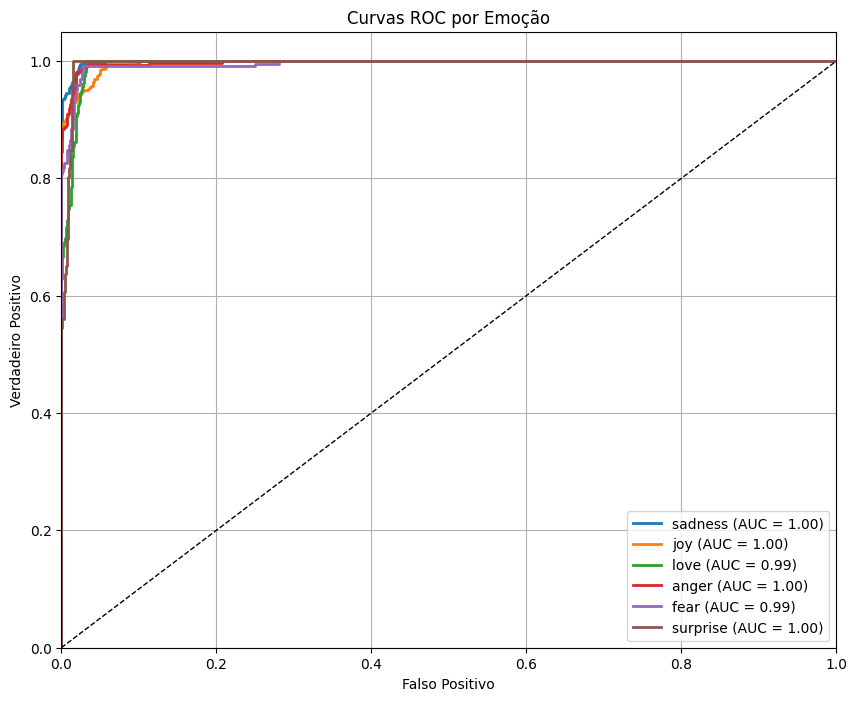

In [35]:
plot_multiclass_roc(y_test, y_pred_proba, classes)

In [36]:

def get_roc_dataframe(y_true, y_probs, class_names):
    n_classes = len(classes)
    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    dataframes = []

    for i in range(n_classes):
        fpr, tpr, thresholds = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)

        df = pd.DataFrame({
            'class': classes[i],
            'fpr': fpr,
            'tpr': tpr,
            'threshold': thresholds,
            'auc': roc_auc  # mesmo valor repetido pra cada linha, pra facilitar agrupamentos
        })

        dataframes.append(df)

    return pd.concat(dataframes, ignore_index=True)


In [37]:
roc_df = get_roc_dataframe(y_test, y_pred_proba,classes)
roc_df

,class,fpr,tpr,threshold,auc
0,sadness,0.000000,0.000000,inf,0.998650
1,sadness,0.000000,0.001721,0.999541,0.998650
2,sadness,0.000000,0.012048,0.999526,0.998650
3,sadness,0.000000,0.015491,0.999523,0.998650
4,sadness,0.000000,0.022375,0.999521,0.998650
...,...,...,...,...,...
483,surprise,0.014995,0.954545,0.119953,0.995558
484,surprise,0.014995,0.984848,0.097808,0.995558
485,surprise,0.015512,0.984848,0.085003,0.995558
486,surprise,0.015512,1.000000,0.067320,0.995558


In [38]:
roc_df.to_csv("curva_roc_por_classe.csv", index=False)

In [39]:
!zip -r wandb.zip /content/wandb

  adding: content/wandb/ (stored 0%)
  adding: content/wandb/latest-run/ (stored 0%)
  adding: content/wandb/latest-run/files/ (stored 0%)
  adding: content/wandb/latest-run/files/output.log (deflated 68%)
  adding: content/wandb/latest-run/files/requirements.txt (deflated 55%)
  adding: content/wandb/latest-run/files/wandb-metadata.json (deflated 46%)
  adding: content/wandb/latest-run/run-74xaradw.wandb (deflated 79%)
  adding: content/wandb/latest-run/logs/ (stored 0%)
  adding: content/wandb/latest-run/logs/debug-core.log (deflated 56%)
  adding: content/wandb/latest-run/logs/debug-internal.log (deflated 85%)
  adding: content/wandb/latest-run/logs/debug.log (deflated 77%)
  adding: content/wandb/latest-run/tmp/ (stored 0%)
  adding: content/wandb/latest-run/tmp/code/ (stored 0%)
  adding: content/wandb/debug-internal.log (deflated 85%)
  adding: content/wandb/debug.log (deflated 77%)
  adding: content/wandb/run-20250409_221742-74xaradw/ (stored 0%)
  adding: content/wandb/run-2025

In [40]:
from google.colab import files
files.download("wandb.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>